# LONG SHORT-TERM MEMORY(LSTM)

### [WATCH THIS](https://www.youtube.com/watch?v=8HyCNIVRbSU)

The **input gate** determines how much
of the input node's value should be added 
to the current memory cell internal state.
The **forget gate** determines whether to keep
the current value of the memory or flush it. 
And the **output gate** determines whether 
the memory cell should influence the output
at the current time step. 

Suppose that there are $h$ hidden units, 
the batch size is $n$, and the number of inputs is $d$.
Thus, the input is $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ 
and the hidden state of the previous time step 
is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$. 
Correspondingly, the gates at time step $t$
are defined as follows: the input gate is $\mathbf{I}_t \in \mathbb{R}^{n \times h}$, 
the forget gate is $\mathbf{F}_t \in \mathbb{R}^{n \times h}$, 
and the output gate is $\mathbf{O}_t \in \mathbb{R}^{n \times h}$. 
They are calculated as follows:

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xi}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hi}} + \mathbf{b}_\textrm{i}),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xf}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hf}} + \mathbf{b}_\textrm{f}),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xo}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{ho}} + \mathbf{b}_\textrm{o}),
\end{aligned}
$$

where $\mathbf{W}_{\textrm{xi}}, \mathbf{W}_{\textrm{xf}}, \mathbf{W}_{\textrm{xo}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hi}}, \mathbf{W}_{\textrm{hf}}, \mathbf{W}_{\textrm{ho}} \in \mathbb{R}^{h \times h}$ are weight parameters 
and $\mathbf{b}_\textrm{i}, \mathbf{b}_\textrm{f}, \mathbf{b}_\textrm{o} \in \mathbb{R}^{1 \times h}$ are bias parameters.


### Input Node


$$\tilde{\mathbf{C}}_t = \textrm{tanh}(\mathbf{X}_t \mathbf{W}_{\textrm{xc}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hc}} + \mathbf{b}_\textrm{c}),$$

where $\mathbf{W}_{\textrm{xc}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hc}} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_\textrm{c} \in \mathbb{R}^{1 \times h}$ is a bias parameter.


### Memory Cell Internal State

In LSTMs, the input gate $\mathbf{I}_t$ governs 
how much we take new data into account via $\tilde{\mathbf{C}}_t$ 
and the forget gate $\mathbf{F}_t$ addresses 
how much of the old cell internal state $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ we retain. 
Using the Hadamard (elementwise) product operator $\odot$
we arrive at the following update equation:

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$


### Hidden State

This is the output of the hidden layer.

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

Whenever the output gate is close to 1, 
we allow the memory cell internal state to impact the subsequent layers uninhibited,
whereas for output gate values close to 0,
we prevent the current memory from impacting other layers of the network
at the current time step. 



### DIAGRAM


![Computing the hidden state in an LSTM model.](../img/lstm-3.svg)

In [1]:
%matplotlib inline
import math
import os
import time
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_hiddens, num_inputs, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        init_weight = lambda *shape: nn.Parameter(torch.randn(shape) *  sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        
        self.W_xi, self.W_hi, self.b_i = triple() # I_t a.k.a. input_gate
        self.W_xf, self.W_hf, self.b_f = triple() # F_t a.k.a. forget gate
        self.W_xo, self.W_ho, self.b_o = triple() # O_t a.k.a. output gate
        self.W_xc, self.W_hc, self.b_c = triple() # C~_t a.k.a. input node

    def forward(self, inputs, prev_state=None): 
        """
        `prev_state`: (prev H, prev C) where H is the hidden state output, C is the internal cell state. 
        So far, it will always be `None` when we call `forward` from `training_step` in d2l.RNNLMScratch)
        `input` is of shape (num_steps, batch_size, num_inputs). 
        `num_steps`: how long 1 sequence is (in tokens).
        `num_inputs`: one-hot encoding of the token.
        """
        if prev_state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
            C = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        else:
            H, C = prev_state
            
        outputs = []
        for X in inputs:
            I = torch.sigmoid(torch.matmul(X, self.W_xi) + torch.matmul(H, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(X, self.W_xf) + torch.matmul(H, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(X, self.W_xo) + torch.matmul(H, self.W_ho) + self.b_o)
            
            C_input = torch.tanh(torch.matmul(X, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c)
            C = F*C + I*C_input
            H = O*torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)

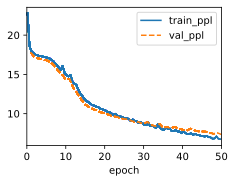

In [54]:
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)

start = time.time()
trainer.fit(model, data)
dur = time.time() - start

In [55]:
print(dur)
print(model.predict("it has ", 10, data.vocab, torch.device("cuda")))

107.58140349388123
it has of the the


In [ ]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)

start = time.time()
trainer.fit(model, data)
dur = time.time() - start

In [57]:
print(dur)
print(model.predict("it has ", 10, data.vocab, torch.device("cuda")))

53.1714301109314
it has and the ti


# Gated Recurrent Units (GRUs)

Mathematically, for a given time step $t$,
suppose that the input is a minibatch
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ 
(number of examples $=n$; number of inputs $=d$)
and the hidden state of the previous time step 
is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ 
(number of hidden units $=h$). 
Then the reset gate $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ 
and update gate $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ are computed as follows:

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xr}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hr}} + \mathbf{b}_\textrm{r}),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xz}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hz}} + \mathbf{b}_\textrm{z}),
\end{aligned}
$$

where $\mathbf{W}_{\textrm{xr}}, \mathbf{W}_{\textrm{xz}} \in \mathbb{R}^{d \times h}$ 
and $\mathbf{W}_{\textrm{hr}}, \mathbf{W}_{\textrm{hz}} \in \mathbb{R}^{h \times h}$ 
are weight parameters and $\mathbf{b}_\textrm{r}, \mathbf{b}_\textrm{z} \in \mathbb{R}^{1 \times h}$ 
are bias parameters.

**Reset gate** controls how much of the previous state 
we might still want to remember. An **update gate** would allow us to control 
how much of the new state is just a copy of the old one.

## Candidate Hidden State

Incorporates the **reset gate** $\mathbf{R}_t$:

$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$ at time step $t$:

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{\textrm{hh}} + \mathbf{b}_\textrm{h}),$$
:eqlabel:`gru_tilde_H`

where $\mathbf{W}_{\textrm{xh}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hh}} \in \mathbb{R}^{h \times h}$
are weight parameters,
$\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$
is the bias,
and the symbol $\odot$ is the Hadamard (elementwise) product operator.
Here we use a tanh activation function.


## Hidden state
Incorporate the **update gate** $\mathbf{Z}_t$: the extent to which the new hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ 
matches the old state $\mathbf{H}_{t-1}$ compared with how much 
it resembles the new candidate state $\tilde{\mathbf{H}}_t$.

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$



## Diagram
![Computing the hidden state in a GRU model.](../img/gru-3.svg)

In [5]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma):
        super().__init__()
        self.save_hyperparameters()
        init_weight = lambda *shape: nn.Parameter(torch.randn(shape) *  sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))

        self.W_xr, self.W_hr, self.b_r = triple()
        self.W_xz, self.W_hz, self.b_z = triple()
        self.W_xh, self.W_hh, self.b_h = triple()

    
    def forward(self, inputs, H=None):
        """
        `H`: previous hidden state output. So far, it will always be `None` when we call `forward` from `training_step` in d2l.RNNLMScratch)
        `inputs` is of shape (num_steps, batch_size, num_inputs). 
        `num_steps`: how long 1 sequence is (in tokens).
        `num_inputs`: one-hot encoding of the token.
        """
        if H is None: 
            H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        
        outputs = []
        for X in  inputs:
            R = torch.sigmoid(torch.matmul(X, self.W_xr) + torch.matmul(H, self.W_hr) + self.b_r)
            Z = torch.sigmoid(torch.matmul(X, self.W_xz) + torch.matmul(H, self.W_hz) + self.b_z)
            H_candidate = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(R*H, self.W_hh) + self.b_h)
            H = Z*H + (1 - Z)*H_candidate
            outputs.append(H)
        return outputs, H

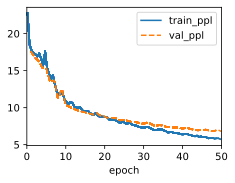

In [59]:
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32, sigma=0.01)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)

start = time.time()
trainer.fit(model, data)
dur = time.time() - start

In [60]:
print(dur)
print(model.predict("it has ", 10, data.vocab, torch.device("cuda")))

101.30772495269775
it has the the th


In [19]:
class GRU(d2l.RNN): 
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

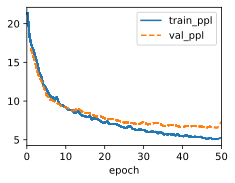

In [62]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)

start = time.time()
trainer.fit(model, data)
dur = time.time() - start

In [63]:
print(dur)
print(model.predict("it has ", 10, data.vocab, torch.device("cuda")))

54.33863186836243
it has of sooned 


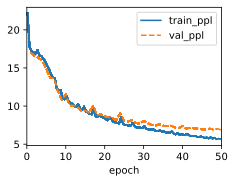

In [64]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)

start = time.time()
trainer.fit(model, data)
dur = time.time() - start

In [65]:
print(dur)
print(model.predict("it has ", 10, data.vocab, torch.device("cuda")))

59.166664361953735
it has a mather t


# Bi-directional Recurrent Neural Networks

Get context from both directions.

![Architecture of a bidirectional RNN.](../img/birnn.svg)
:label:`fig_birnn`


Formally for any time step $t$,
we consider a minibatch input $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ 
(number of examples $=n$; number of inputs in each example $=d$) 
and let the hidden layer activation function be $\phi$.
In the bidirectional architecture,
the forward and backward hidden states for this time step 
are $\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ 
and $\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$, respectively,
where $h$ is the number of hidden units.
The forward and backward hidden state updates are as follows:


$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{\textrm{xh}}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{\textrm{hh}}^{(f)}  + \mathbf{b}_\textrm{h}^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{\textrm{xh}}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{\textrm{hh}}^{(b)}  + \mathbf{b}_\textrm{h}^{(b)}),
\end{aligned}
$$

where the weights $\mathbf{W}_{\textrm{xh}}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{\textrm{hh}}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{\textrm{xh}}^{(b)} \in \mathbb{R}^{d \times h}, \textrm{ and } \mathbf{W}_{\textrm{hh}}^{(b)} \in \mathbb{R}^{h \times h}$, and the biases $\mathbf{b}_\textrm{h}^{(f)} \in \mathbb{R}^{1 \times h}$ and $\mathbf{b}_\textrm{h}^{(b)} \in \mathbb{R}^{1 \times h}$ are all the model parameters.

Next, we concatenate the forward and backward hidden states
$\overrightarrow{\mathbf{H}}_t$ and $\overleftarrow{\mathbf{H}}_t$
to obtain the hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$ for feeding into the output layer.
In deep bidirectional RNNs with multiple hidden layers,
such information is passed on as *input* to the next bidirectional layer. 
Last, the output layer computes the output 
$\mathbf{O}_t \in \mathbb{R}^{n \times q}$ (number of outputs $=q$):

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{\textrm{hq}} + \mathbf{b}_\textrm{q}.$$

Here, the weight matrix $\mathbf{W}_{\textrm{hq}} \in \mathbb{R}^{2h \times q}$ 
and the bias $\mathbf{b}_\textrm{q} \in \mathbb{R}^{1 \times q}$ 
are the model parameters of the output layer. 


### we don't have **MEMORY** in this one!

In [66]:
class BiRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.f_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.b_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.num_hiddens *= 2

    def forward(self, inputs, Hs=None):
        """
        `Hs`: (prev f_H, prev b_H). So far, it will always be `None` when we call `forward` from `training_step` in d2l.RNNLMScratch)
        `inputs` is of shape (num_steps, batch_size, num_inputs). 
        """
        if Hs is None:
            f_H, b_H = (None, None)
        else:
            f_H, b_H = Hs
        f_outputs, f_H = self.f_rnn(inputs, f_H)
        b_outputs, b_H = self.b_rnn(reversed(inputs), b_H)
        outputs = []
        for f, b in zip(f_outputs, reversed(b_outputs)):
            outputs.append(torch.cat((f, b), -1))
        return outputs, (f_H, b_H)

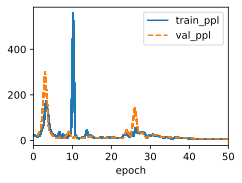

In [67]:
bi_rnn = BiRNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(bi_rnn, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)

start = time.time()
trainer.fit(model, data)
dur = time.time() - start

In [ ]:
print(dur)
print(model.predict("it has ", 10, data.vocab, torch.device("cuda")))

# Sequence Translation

Convert raw text -> sequences of tokens -> padding/trimming to a fixed length -> generate a vocab -> sequences of encoded tokens for training and predicting

In [8]:
class MTFraEng(d2l.DataModule):  #@save
    """The English-French dataset."""
    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
        super().__init__()
        self.save_hyperparameters()
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays()
    
    def _build_arrays(self, raw_text=None, src_vocab=None, tgt_vocab=None):
        """
        Create data arrays.
        In the process, also convert each token into the corresponding index in `vocab`.
        """
        if raw_text is None:
            raw_text = self._download()
        src, tgt = self._tokenize(self._preprocess(raw_text), max_examples=self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = self._build_array(src, src_vocab)
        tgt_array, tgt_vocab, tgt_valid_len = self._build_array(tgt, tgt_vocab, is_tgt=True)
        return ((src_array, tgt_array[:, :-1], src_valid_len, tgt_array[:, 1:]), src_vocab, tgt_vocab)
    
    def _build_array(self, sequence_list, vocab=None, is_tgt=False):
        """
        Pad/trim each sequence of token to a fixed length.
        Returns a tuple of (fixed sequence, vocab of `sequence_list`, length of fixed sequence without padding).
        """
        pad_or_trim = lambda seq: (seq + ["<pad>"]*(self.num_steps-len(seq)) if len(seq) < self.num_steps 
                                   else seq[:self.num_steps])
        sentences = []
        sentences = [pad_or_trim(s) for s in sequence_list] # pad/trim each sentence to get a fixed length.
        
        if is_tgt:
            res = [["<bos>"] + s for s in sentences]     # for predicting sequences, "<bos>" will be the 1st token.
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
            
        res = torch.tensor([vocab[s] for s in sentences])
        len_without_padding = (res != vocab["<pad>"]).to(torch.int32).sum(1) # number of tokens without padding
        return res, vocab, len_without_padding

    def build(self, src_sentences, tgt_sentences):
        """
        return data arrays of raw text.
        """
        raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(src_sentences, tgt_sentences)])
        arrays, _, _ = self._build_arrays(raw_text, self.src_vocab, self.tgt_vocab)
        return arrays

    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

    def _preprocess(self, raw_text):
        """
        Replace non-breaking space with space and 
        insert space between words and punctuation marks."""
        # Replace non-breaking space with space
        text = raw_text.replace("\u202f", " ").replace("\xa0", " ")
        no_space = lambda char, prev_char: char in ",.!?" and prev_char != " "
        # Insert space between words and punctuation marks
        out = [" " + char if i > 0 and no_space(char, text[i-1]) else char
              for i, char in enumerate(text.lower())]
        return ''.join(out)

    def _tokenize(self, text, max_examples=None):
        """
        Tokenizes the first `max_examples` text sequence pairs
        """
        # tokenized source & target language
        src, tgt = [], []
        for i, line in enumerate(text.split("\n")):
            if max_examples is not None and i > max_examples: 
                break
            parts = line.split("\t")
            if len(parts) == 2: 
                # skip empty tokens
                src.append([t for t in f"{parts[0]} <eos>".split(" " ) if t]) 
                tgt.append([t for t in f"{parts[1]} <eos>".split(" " ) if t]) 
        return src, tgt

    def get_dataloader(self, train=False):
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)
        

data = MTFraEng(batch_size=3)
raw_text = data._download()
print(raw_text[:75])
text = data._preprocess(raw_text)
print(text[:80])
src, tgt = data._tokenize(text)
print(src[:5])
print(tgt[:5])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !
[['go', '.', '<eos>'], ['hi', '.', '<eos>'], ['run', '!', '<eos>'], ['run', '!', '<eos>'], ['who', '?', '<eos>']]
[['va', '!', '<eos>'], ['salut', '!', '<eos>'], ['cours', '!', '<eos>'], ['courez', '!', '<eos>'], ['qui', '?', '<eos>']]


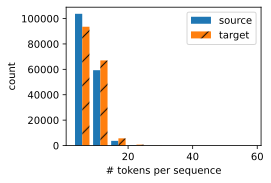

In [9]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist([ [len(l) for l in xlist],
                                   [len(l) for l in ylist],
                                 ])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch("/")
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', src, tgt);

In [10]:
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print("source shape: ", src.shape)
print('decoder input:', tgt.type(torch.int32))
print("decoder input shape: ", tgt.shape)
print('source len excluding pad:', src_valid_len.type(torch.int32))
print("source len excluding pad shape: ", src_valid_len.shape)
print('label:', label.type(torch.int32))
print("label shape: ", label.shape)

rc, tgt, _,  _ = data.build(['hi .'], ['salut .'])
print('source build :', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target build:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: tensor([[181, 111,   2,   3,   4,   4,   4,   4,   4],
        [151, 174,   0,   3,   4,   4,   4,   4,   4],
        [ 84, 105,   2,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
source shape:  torch.Size([3, 9])
decoder input: tensor([[  5,   0,   3,   4,   4,   4,   4,   4],
        [  5, 150,  88,   0,   3,   4,   4,   4],
        [104, 147,   2,   3,   4,   4,   4,   4]], dtype=torch.int32)
decoder input shape:  torch.Size([3, 8])
source len excluding pad: tensor([4, 4, 4], dtype=torch.int32)
source len excluding pad shape:  torch.Size([3])
label: tensor([[  0,   3,   4,   4,   4,   4,   4,   4],
        [150,  88,   0,   3,   4,   4,   4,   4],
        [147,   2,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
label shape:  torch.Size([3, 8])
source build : ['watch', 'me', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target build: ['salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


# Encoder-Decoder Architecture

An **encoder** that takes a *variable-length* sequence as input 
and transforms it into an **encoded state** with a *fixed shape*,

A **decoder** takes that *fixed shape* **encoded state** and a leftwards context of the target sequence and maps it to a *variable-length* sequence.

Later, with **attention mechanisms**, the encoded state won't have to be of fixed-length.

The encoder takes a variable-length sequence as input and . The decoder maps the encoded state of a fixed shape to a variable-length sequence.


![The encoder--decoder architecture.](../img/encoder-decoder.svg)
:label:`fig_encoder_decoder`


In [11]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        raise NotImplementedError

In [12]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    def init_state(self, enc_all_outputs, *args):
        """
        convert the encoder output `enc_all_outputs` into the encoded state.
        """
        raise NotImplementedError

    def forward(self, X, state):
        """
        To generate a variable-length sequence token by token, every time the decoder may 
        map an input (e.g., the generated token at the previous time step) 
        and the encoded state into an output token at the current time step.
        """
        raise NotImplemetedError

In [13]:
class EncoderDecoder(d2l.Classifier):  #@save
    """The base class for the encoder--decoder architecture."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

# Sequence-to-Sequence Learning for Machine Translation
During training, the decoder is conditioned upon the preceding tokens
in the official "ground truth" label. 

However, at test time, we will want to condition
each output of the decoder on the tokens already predicted. 
Note that if we ignore the encoder,
the decoder in a sequence-to-sequence architecture 
behaves just like a normal language model.
:numref:`fig_seq2seq` illustrates
how to use two RNNs
for sequence-to-sequence learning
in machine translation.


![Sequence-to-sequence learning with an RNN encoder and an RNN decoder.](../img/seq2seq.svg)
:label:`fig_seq2seq`

First, we begin every input with a special 
beginning-of-sequence "&lt;bos&gt;" token.
Second, we may feed
the final hidden state of the encoder
into the decoder
at every single decoding time step.


## Encoder

Consider a single sequence example (batch size 1).
Suppose the input sequence is $x_1, \ldots, x_T$, 
such that $x_t$ is the $t^{\textrm{th}}$ token.
At time step $t$, the RNN transforms
the input feature vector $\mathbf{x}_t$ for $x_t$
and the hidden state $\mathbf{h} _{t-1}$ 
from the previous time step 
into the current hidden state $\mathbf{h}_t$.
We can use a function $f$ to express 
the transformation of the RNN's recurrent layer:

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$

In general, the encoder transforms 
the hidden states at all time steps
into a context variable through a customized function $q$:

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$
In this example, we have used a unidirectional RNN
to design the encoder. Bidirectional is fine as well.

We use an *embedding layer*
to obtain the feature vector for each token in the input sequence.

The weight of an embedding layer is a matrix of dim (`vocab_size`, `embed_size`).
For any input $i$ = token's index in the vocab,
the embedding layer fetches the $i^{\textrm{th}}$ row 
(starting from 0) of the weight matrix
to return the **weighted feature vector of the $i^{\textrm{th}}$ token in the vocab**.


In [18]:
def init_seq2seq(module): #@save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder): #@save
    """ The RNN encoder for seq2seq learning. """
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        """
        X: batch of sequences of tokens
        X's shape: (batch_size, num_steps)
        """
        embs = self.embedding(X.t().type(torch.int64))
        # embs' shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [17]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)

d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))

# Decoder

Given a target output sequence (NOT the encoder's output sequence) $y_1, y_2, \ldots, y_{T'}$
for each time step $t'$
(we use $t^\prime$ to differentiate from the input sequence time steps),
the decoder assigns a predicted probability
to each possible token occurring at step $y_{t'+1}$
conditioned upon the previous tokens in the target
$y_1, \ldots, y_{t'}$ 
and the context variable 
$\mathbf{c}$ (encoder's output), i.e., $P(y_{t'+1} \mid y_1, \ldots, y_{t'}, \mathbf{c})$.


To predict the subsequent token $t^\prime+1$ in the target sequence,
the RNN decoder takes the previous step's target token $y_{t^\prime}$,
the hidden RNN state from the previous time step $\mathbf{s}_{t^\prime-1}$,
and the context variable $\mathbf{c}$ as its input,
and transforms them into the hidden state 
$\mathbf{s}_{t^\prime}$ at the current time step.

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$
:eqlabel:`eq_seq2seq_s_t`

Then, use an output layer and the softmax operation 
to compute the predictive distribution
$p(y_{t^{\prime}+1} \mid y_1, \ldots, y_{t^\prime}, \mathbf{c})$ 
over the subsequent output token ${t^\prime+1}$.

We directly use the hidden state at the final time step
of the encoder
to initialize the hidden state of the decoder.

To further incorporate the encoded input sequence information, the context variable is concatenated with the decoder input at all the time steps

=> Requires the RNN encoder and the RNN decoder 
to have the same number of layers and hidden units.

In [25]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 1st arg - the length of the feature vector - is `embed_size+num_hiddens` because we concat the 
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        """
        X's shape: (batch_size, num_steps): batches of target output sequence
        state contains (encoder's ALL outputs, prev decoder hidden state)
        """
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # concat embs and context at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        # outputs' shape: (num_steps, batch_size, num_hiddens)
        # new_hidden_state's shape: (batch_size, num_hiddens)
        outputs, new_hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1) # swap axes to prepare for softmax
        return outputs, [enc_output, new_hidden_state]

In [26]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)

d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

## Encoder-Decoder for Seq2Seq

In [33]:
class Seq2Seq(d2l.EncoderDecoder): #@save
    """ The RNN Encoder-Decoder architecture for Seq2Seq Learning """
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.lr)

    def loss(self, Y_hat, Y):
        # call d2l.Classifier.loss which computes the cross-entropy loss: https://stackoverflow.com/a/57164297
        # don't average right now cause we need to exclude predictions of padding tokens first.
        l = super().loss(Y_hat, Y, averaged=False)
        # prediction of padding tokens should be excluded from loss calculations. 
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        # now we average
        return ((l * mask).sum()) / mask.sum() 

    def predict_step(self, batch, device, num_steps, save_attention_weights=False):
        batch = [b.to(device) for b in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_wegihts = [tgt[:, (0)].unsqueeze(1), ], [] # https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(Y.argmax(2)) # get token with the highest prob
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights 

In [ ]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab["<pad>"], lr=0.005)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=2)

start = time.time()
trainer.fit(model, data)
dur = time.time() - start